# Checkpoint analysis

Use this notebook to analyse checkpoints produced by `q1physrl_train`

Change the below to refer to the params / checkpoint that you wish to analyse

In [1]:
PARAMS_FNAME = '../data/checkpoints/wr/params.json'
CHECKPOINT_FNAME = '../data/checkpoints/wr/checkpoint'

All imports go here

In [ ]:
import dataclasses
import json

import matplotlib.pyplot as plt
import numpy as np
import ray

from q1physrl import analyse, train
from q1physrl_env import env

Load the trainer

In [ ]:
with open(PARAMS_FNAME) as f:
    params = json.load(f)
ray.init(memory=100 << 20, object_store_memory=100 << 20)
trainer = train.make_trainer({'trainer_class': 'PPOTrainer', 'trainer_config': params})
trainer.restore(CHECKPOINT_FNAME)

Do a rollout of a single episode

In [ ]:
env_config = dataclasses.replace(env.Config(**params['env_config']),
                                 zero_start_prob=1,
                                 num_envs=1)
r = analyse.eval_sim(trainer, env_config)

Plot of `wish_angle - yaw` over time, with optimal values highlighted

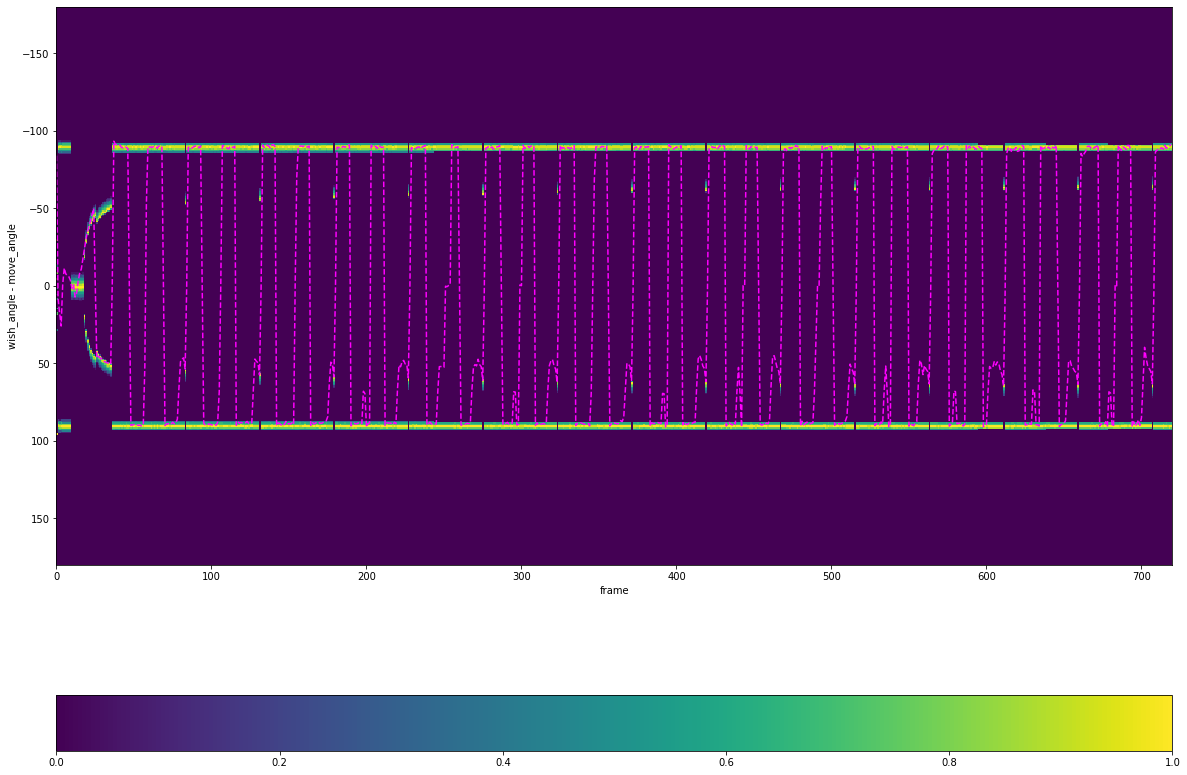

In [5]:
r.wish_angle_yaw_plot()

Plot some metrics over time

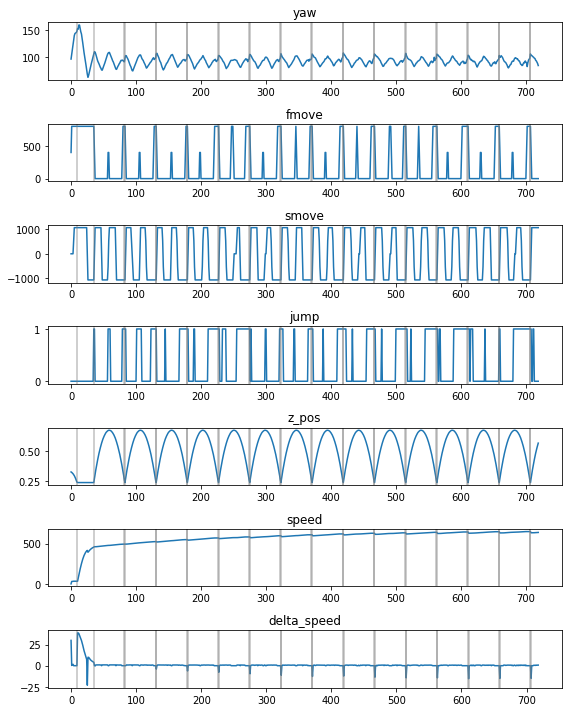

In [6]:
curves = {
    'yaw': r.yaw,
    'fmove': r.fmove,
    'smove': r.smove,
    'jump': r.jump,
    'z_pos': r.obs[:, env.Obs.Z_POS],
    'speed': np.linalg.norm(r.player_state.vel[:, :2], axis=1),
    'delta_speed': np.diff(np.linalg.norm(r.player_state.vel[:, :2], axis=1)),
}

jump_times = np.where(np.diff(r.player_state.vel[:, 2]) > 10)[0]

fig, plots = plt.subplots(len(curves), 1)
fig.set_figwidth(8)
fig.set_figheight(10)
for plot, (label, y) in zip(plots, curves.items()):
    plot.set_title(label)
    plot.plot(y)
    for t in jump_times:
        plot.axvline(t, alpha=0.5, color='gray')
plt.tight_layout()

Plot max attainable speed delta against obtained speed delta

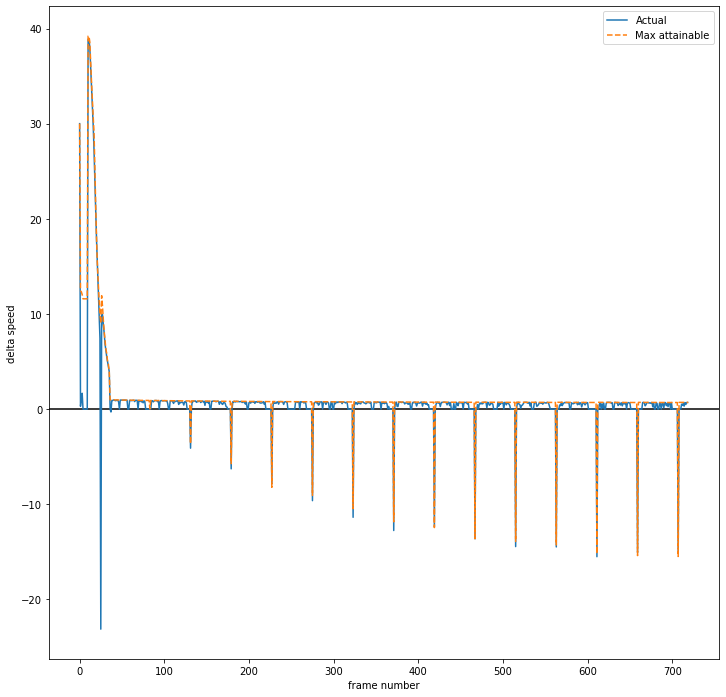

In [7]:
plt.figure(figsize=(12, 12))
plt.axhline(0, color='black')
plt.xlabel('frame number')
plt.ylabel('delta speed')
plt.plot(np.diff(np.linalg.norm(r.player_state.vel[:, :2], axis=1)), label='Actual')
plt.plot(np.max(r.hypothetical_delta_speeds, axis=0), label='Max attainable', linestyle='--')
plt.legend()

Velocity vector plot

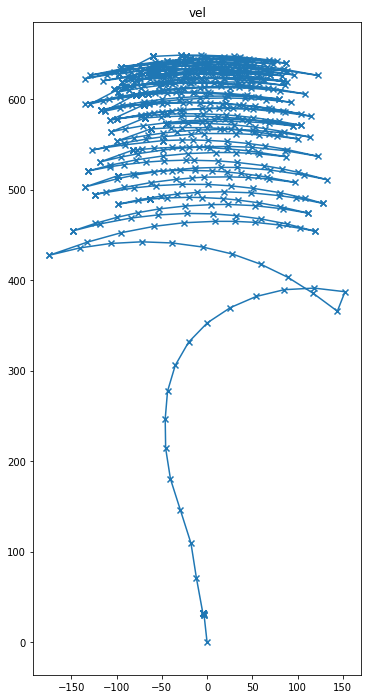

In [8]:
vel = r.player_state.vel

plt.figure(figsize=(12, 12))
plt.axes().set_aspect('equal')
plt.title('vel')
plt.plot(vel[:, 0], vel[:, 1])
plt.scatter(vel[:, 0], vel[:, 1], marker='x')